## Задание
Проведение разведочного анализа включает в себя такие подзадачи как:
- частотный анализ коллекции(например распределение количества слов в документах)
- выбор пространства признаков с обоснование данных признаков
- визуализация данных
- подсчет статистических параметров для коллекции с использованием выбранных признаков(например среднее, стандартное отклонение, квартили и тд)
- поиск выбросов и аномалий, их анализ, выбор методов детектирования аномалий и их обработки
- корреляционный анализ(например, построенные парные диаграммы рассеяния различных признаков, их гистограммы распределения, корреляционные матрицы, проверка гипотезы о гомоскедастичности данных и подобных ей)
- выбор целевых переменных для задач классификации документов по темам на основе тегов и предсказания рейтинга документа.
построение распределения и анализ целевых переменных

Для полноты анализа могут быть описаны различные преобразования данных и их анализ, применение PCA, анализ feature importance, поиск ложных корреляций.
После проведения каждого анализа следует фиксировать выводы о полученных результатах.
Для сдачи необходимо представить ноутбуки в которых проведен соответствующий анализ и описаны выводы и рекомендации по работе с данной коллекцией, а также скрипты на выбранном языке программирования.


In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from preprocess import preprocess_text

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams["axes.grid"] = True

Непосредственно перед анализом проведем небольшую предобработку, переведя время в удобный формат, удалив теги, встречающиеся один раз, а также переведя строковые значения полей "tag", "subreddit" и "topic" в категориальные.

In [2]:
data = pd.read_csv("data/preprocessed_reddit_submissions.csv")
data["time_created"] = data["time_created"].apply(pd.Timestamp.fromtimestamp)
data["text_len"] = data["text"].apply(len)
data["tag"] = data["tag"].apply(str).apply(preprocess_text)
single_tags = data["tag"].value_counts()
single_tags = list(single_tags[single_tags == 1].index)
data.loc[data["tag"].isin(single_tags), "tag"] = None

In [3]:
for column in "subreddit", "tag", "topic":
    sorted_values_by_count = sorted(data[column].unique(), key=lambda x: len(data[data[column] == x]), reverse=True)
    value_to_id = {k: v for k, v in zip(sorted_values_by_count, range(len(sorted_values_by_count)))}
    data[column + "_id"] = data[column].map(value_to_id)
data.head()

,author,is_submission,is_submitter,num_comments,over_18,tag,text,time_created,score,subreddit,topic,text_len,subreddit_id,tag_id,topic_id
0,fouoifjefoijvnioviow,True,True,18.0,False,nan,my take on the 90s were so great the last of t...,2022-04-28 04:14:25,34,90s,other,6326,804,0,0
1,KarmaHit,True,True,102.0,False,nan,the small general memories that give you 90s n...,2022-03-12 01:29:44,295,90s,other,2126,804,0,0
2,SparkleFritz,False,False,NaN,NaN,nan,my girl is the only thing in my husband and is...,2021-09-15 12:48:28,38,90s,other,3703,804,0,0
3,DarkKirby9970,True,True,39.0,False,nan,would it be fair to say that the 90s culturall...,2022-03-05 02:53:41,6,90s,other,2828,804,0,0
4,RetailSlave5408,True,True,8.0,False,nan,thoughts on the 1998 jack frost just saw it fo...,2021-12-20 12:36:47,0,90s,other,2213,804,0,0


## Частотный анализ

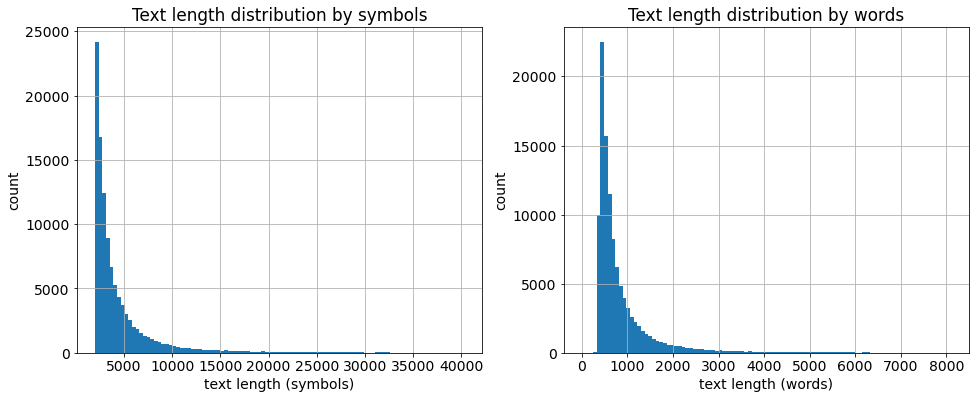

In [6]:
figure, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].hist(data["text_len"], bins=100)
ax[0].set_xlabel("text length (symbols)")
ax[0].set_ylabel("count")
ax[0].set_title("Text length distribution by symbols")

ax[1].hist(data["text"].apply(lambda x: len(x.split())), bins=100)
ax[1].set_xlabel("text length (words)")
ax[1].set_ylabel("count")
ax[1].set_title("Text length distribution by words");

In [7]:
for column_name in "is_submission", "is_submitter", "over_18":
    print("Column: " + column_name, data[column_name].value_counts(), sep="\n", end="\n\n")

Column: is_submission
True     104890
False      3147
Name: is_submission, dtype: int64

Column: is_submitter
True     104996
False      3041
Name: is_submitter, dtype: int64

Column: over_18
False    102824
True       2066
Name: over_18, dtype: int64



In [8]:
print("Percent of comments written by the submission authors {:.3}%".format(
    data[~data.is_submission].is_submitter.sum() / len(data[~data.is_submission]) * 100)
)

Percent of comments written by the submission authors 3.37%


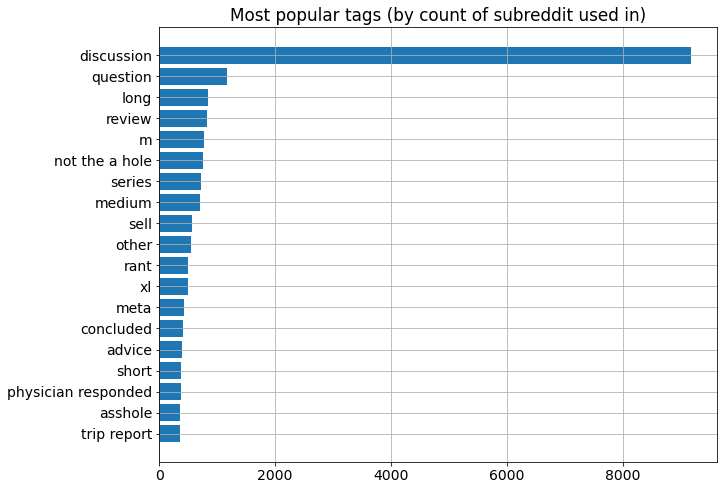

In [9]:
# Наиболее популярные теги
tags = data["tag"].value_counts()
top = 20
fig, ax = plt.subplots(figsize=(10, int(top * 0.4)))
ax.barh(y=tags[1:top].index, width=tags[1:top].values)
ax.set_title("Most popular tags (by count of subreddit used in)")
ax.invert_yaxis()

Среди наиболее популярные тегов встречаются "discussion", "answer", "review" и "advice", что вполне объяснимо. С другой стороны, не понятно, почему среди топ 20 оказался тег "short", а также тег "question", занимающий 2 позицию (обычно вопросы короткие, в отличие от ответов)

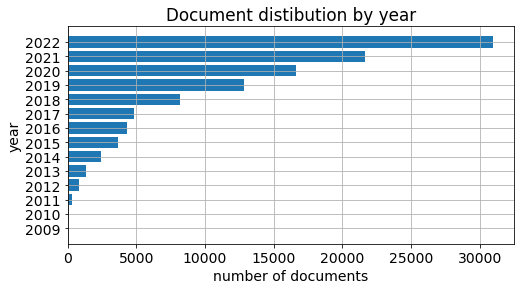

In [10]:
years = data["time_created"].apply(lambda x:x.year).value_counts()
fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(list(map(str, years.index)), years.values)
ax.invert_yaxis()
ax.set_title("Document distibution by year")
ax.set_xlabel("number of documents")
ax.set_ylabel("year");

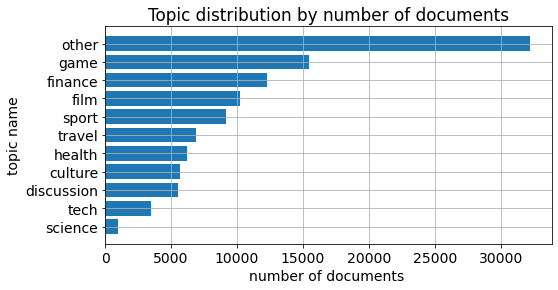

In [11]:
topics = data["topic"].value_counts()
fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(y=topics.keys(), width=topics.values)
ax.invert_yaxis()
ax.set_title("Topic distribution by number of documents")
ax.set_xlabel("number of documents ")
ax.set_ylabel("topic name");

Так как поля "num_comments" и "over_18" не имеют значений для комментариев, некоторые шаги анализа будут применять только к части коллекции, состоящей из постов (комментарии составляют лишь 2% от всей коллекции). На других этапах, где наличие этих полей не будет иметь значение, будет использоваться полная коллекция.

Для части коллекции, состоящей из постов, поле "is_submitter" не несет никакой информации, поэтому он будет удален вместе с полем "is_submission".

In [12]:
sbm_data = data[data["is_submission"]].drop(columns=["is_submission", "is_submitter"])
cmt_data = data[~data["is_submission"]].drop(columns=["is_submission", "num_comments", "over_18"])
sbm_data.head()

,author,num_comments,over_18,tag,text,time_created,score,subreddit,topic,text_len,subreddit_id,tag_id,topic_id
0,fouoifjefoijvnioviow,18.0,False,nan,my take on the 90s were so great the last of t...,2022-04-28 04:14:25,34,90s,other,6326,804,0,0
1,KarmaHit,102.0,False,nan,the small general memories that give you 90s n...,2022-03-12 01:29:44,295,90s,other,2126,804,0,0
3,DarkKirby9970,39.0,False,nan,would it be fair to say that the 90s culturall...,2022-03-05 02:53:41,6,90s,other,2828,804,0,0
4,RetailSlave5408,8.0,False,nan,thoughts on the 1998 jack frost just saw it fo...,2021-12-20 12:36:47,0,90s,other,2213,804,0,0
5,CormanMedia,9.0,False,nan,90s movies were awesome except for titanicthis...,2020-12-12 01:21:44,2,90s,other,2732,804,0,0


## Выбросы

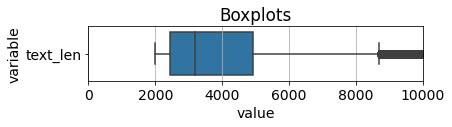

In [13]:
plt.figure(figsize=(6, 1))
sns.boxplot(x="value", y="variable", data=pd.melt(sbm_data[["text_len"]]))
plt.xlim(0, 10000)
plt.title("Boxplots")
plt.show()

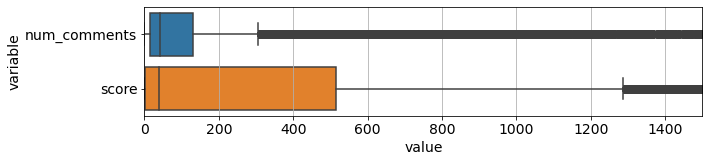

In [14]:
plt.figure(figsize=(10, 2))
sns.boxplot(x="value", y="variable", data=pd.melt(sbm_data[["num_comments", "score"]]))
plt.xlim(0, 1500)
plt.show()

In [15]:
upper_limit = {}
for column in "num_comments", "score":
    upper_limit[column] = 2.5 * sbm_data[column].quantile(q=0.75) - 1.5 * sbm_data[column].quantile(q=0.25)
boxplot_outliers = np.logical_or(*[sbm_data[column] > upper_limit[column] for column in upper_limit])

Outliers percent: 19.2%


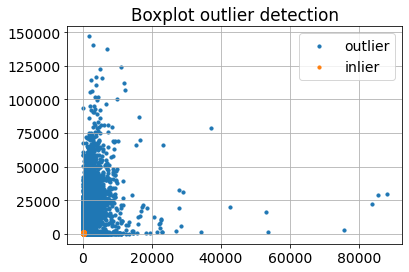

In [16]:
plt.scatter(sbm_data[boxplot_outliers]["num_comments"], sbm_data[boxplot_outliers]["score"], s=10, label="outlier")
plt.scatter(sbm_data[~boxplot_outliers]["num_comments"], sbm_data[~boxplot_outliers]["score"], s=10, label="inlier")
plt.title("Boxplot outlier detection")
plt.legend()
print("Outliers percent: {:.3}%".format(boxplot_outliers.sum() / len(sbm_data) * 100))

Видно, что метод с использование межквантильного размаха довольно грубый, так как удаляет почти 20% данных. Попробуем еще два метода

Outliers percent: 0.4%


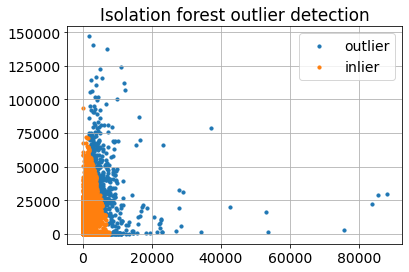

In [17]:
points = sbm_data[["num_comments", "score"]].values
isf = IsolationForest(n_estimators=100, warm_start=True, contamination=0.004)
isf_outliers = isf.fit_predict(points) == -1

plt.scatter(points[isf_outliers][:, 0], points[isf_outliers][:, 1], s=10, label="outlier")
plt.scatter(points[~isf_outliers][:, 0], points[~isf_outliers][:, 1], s=10, label="inlier")
plt.title("Isolation forest outlier detection")
plt.legend()
print(f"Outliers percent: {(isf_outliers.sum() / len(points)) * 100:.2}%")

Outliers percent: 1.7%


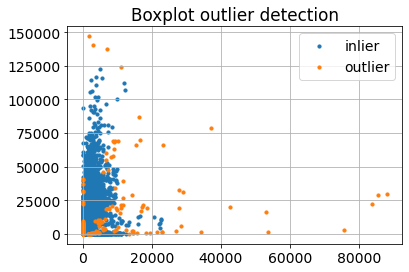

In [18]:
locf = LocalOutlierFactor(n_neighbors=20, algorithm="ball_tree")
locf_outliers = locf.fit_predict(points) == -1

plt.scatter(points[~locf_outliers][:, 0], points[~locf_outliers][:, 1], s=10, label="inlier")
plt.scatter(points[locf_outliers][:, 0], points[locf_outliers][:, 1], s=10, label="outlier")
plt.title("Boxplot outlier detection")
plt.legend()
print(f"Outliers percent: {(locf_outliers.sum() / len(points)) * 100:.2}%")

После небольшого настройки гиперпараметров модели IsolationForest получилась более щадящая модель обнаружения выбросов. Модель LocalOutlierFactor плохо справляется с обнаружением выбросов в данной коллекции, либо требует более длительного подбора гиперпараметров.

## Корреляционный анализ

Так как коллекция довольно большая, отображение всех текстов на диаграммах приведет к их заграможденности, а также увеличит время построения диаграмм. Поэтому будем рассмотривать случайную выборку из 10 000 документов.

In [19]:
pairplot_columns = ["text_len", "num_comments", "score", "topic"]
sampled_sbm_data = sbm_data.sample(10000)

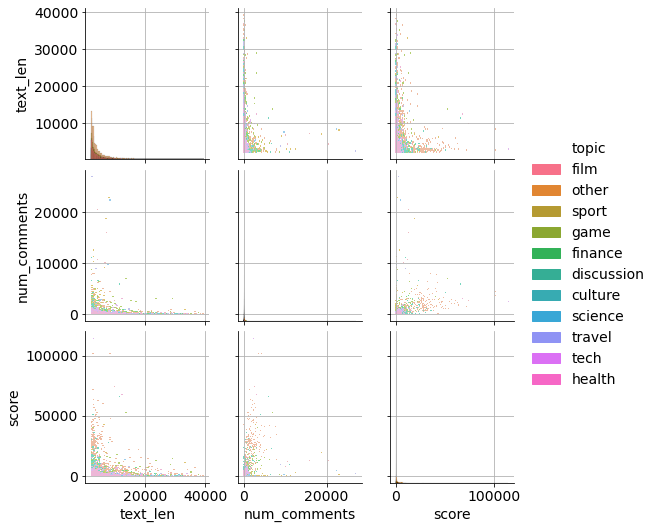

In [20]:
# Парные диаграммы рассеяния до удаления выбросов
sns.pairplot(sampled_sbm_data[pairplot_columns], kind="hist", hue="topic")

По данным диаграммам все еще тяжело что-то сказать, так как в основном документы сконцентрированы в левом нижнем углу при низких значениях признаков, а темы перемешаны. Чтобы рассмотреть более подробно эти области, удалим обнаруженные на предыдущем шаге выбросы. Ниже будет использовано удаление с помощью боксплотов, чтобы более подробно посмотреть на основную часть коллекции. 

In [26]:
sbm_data_wo_outliers = sbm_data[~boxplot_outliers].sample(10000)

10000

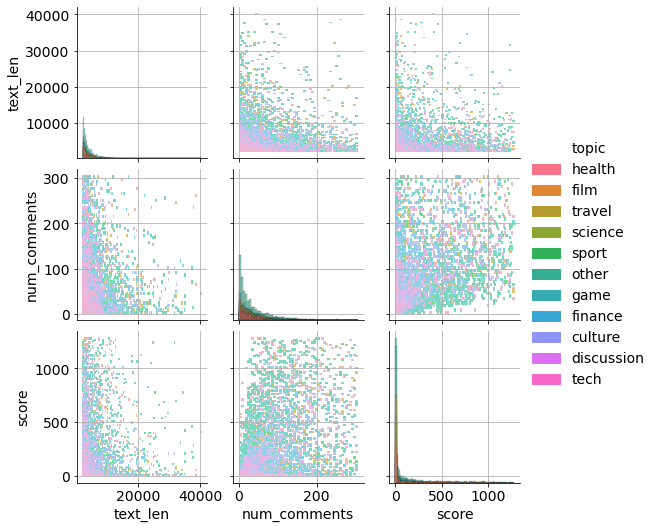

In [27]:
sns.pairplot(sbm_data_wo_outliers[pairplot_columns], kind="hist", hue="topic")
len(sbm_data_wo_outliers)

Можно заметить слабую зависимость между количеством комментариев и оценкой. Ниже представлена отдельная диаграмма. Можно сделать следующие выводы:
1. Мало комментируемые посты (до 10-25 комментариев) обычно получают не высокие оценки (до 600 - 800). Видно, что белая наиболее разреженная зона находится в верхнем левом углу.
2. При увеличении количества комментариев дисперсия оценок сначала растет (от 0 до 50-70 комментариев), а затем начинает падать

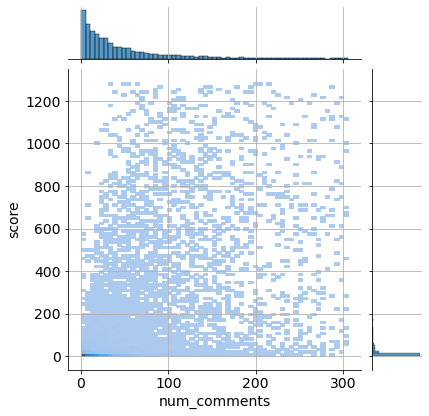

In [28]:
sns.jointplot(data=sbm_data_wo_outliers, x="num_comments", y="score", kind="hist")

In [29]:
sbm_data[pairplot_columns].corr()

,text_len,num_comments,score
text_len,1.000000,0.002421,0.013412
num_comments,0.002421,1.000000,0.432573
score,0.013412,0.432573,1.000000


In [30]:
sampled_sbm_data[pairplot_columns].corr()

,text_len,num_comments,score
text_len,1.000000,0.006909,0.021141
num_comments,0.006909,1.000000,0.428732
score,0.021141,0.428732,1.000000


In [31]:
sbm_data_wo_outliers[pairplot_columns].corr()

,text_len,num_comments,score
text_len,1.000000,0.051423,0.111893
num_comments,0.051423,1.000000,0.507922
score,0.111893,0.507922,1.000000


Сэмплирование сохранило распределение и корреляции между признаками, а избавление от выбросов немного увеличило парные корреляции.

Зависимость между сабреддитами, имеющими тенденцию к более длинным постам, и более популярными тегами тоже не прослеживается.

,subreddit_id,tag_id,topic_id
subreddit_id,1.000000,0.133071,0.195944
tag_id,0.133071,1.000000,0.041136
topic_id,0.195944,0.041136,1.000000


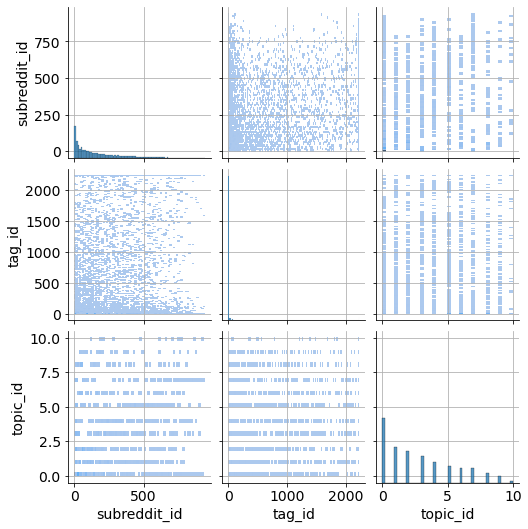

In [31]:
sns.pairplot(data=sbm_data_wo_outliers[["subreddit_id", "tag_id", "topic_id"]], kind="hist")
data[["subreddit_id", "tag_id", "topic_id"]].corr()

## Статистические параметры

Столбцы "num_comments", "score" и "text_len" имеют схожее экспоненциальное распределение, большая часть сконцентрирована в начале при малых значениях. Также заметна большая разница между медианой и средним, а также большие значения среднеквадратичного отклонения

In [33]:
sbm_data_wo_outliers = sbm_data[~isf_outliers]
sbm_data_wo_outliers.describe()

,num_comments,score,text_len,subreddit_id,tag_id,topic_id
count,104470.000000,104470.000000,104470.000000,104470.000000,104470.000000,104470.000000
mean,172.504834,1293.969015,4571.624476,171.987260,162.235570,2.772183
std,474.755238,4511.238087,3995.027784,186.762325,423.957507,2.778570
min,0.000000,0.000000,2001.000000,0.000000,0.000000,0.000000
25%,14.000000,2.000000,2437.000000,25.000000,0.000000,0.000000
50%,43.000000,39.000000,3173.000000,100.000000,1.000000,2.000000
75%,129.000000,502.000000,4935.000000,265.000000,75.000000,5.000000
max,10981.000000,147047.000000,40272.000000,941.000000,2363.000000,10.000000


## Визуализация данных

In [34]:
from plotly import express as px
px.scatter_3d(sbm_data_wo_outliers.sample(1000), x="num_comments", y="score", z="text_len", color="topic_id")

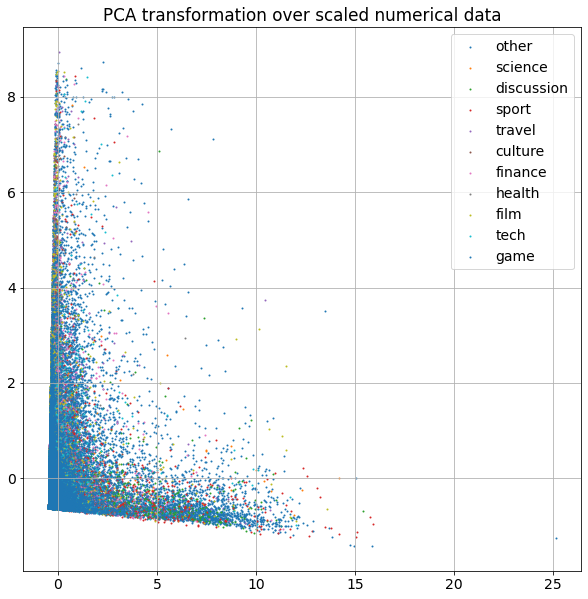

In [36]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sbm_data_wo_outliers[["num_comments", "score", "text_len"]])

pca = PCA(n_components=2)
pca_repr = pca.fit_transform(scaled_data)
plt.figure(figsize=(10, 10))
for topic in sbm_data["topic"].unique():
    plt.scatter(
        x=pca_repr[sbm_data_wo_outliers["topic"] == topic][:, 0],
        y=pca_repr[sbm_data_wo_outliers["topic"] == topic][:, 1],
        s=1,
        label=topic
    )
plt.legend()
plt.title("PCA transformation over scaled numerical data");

In [37]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
# nltk.download("stopwords")

tfidf_model = TfidfVectorizer(max_features=10000, sublinear_tf=True, stop_words=stopwords.words("english"))
pca_tfidf_model = PCA(n_components=2)
pca_tfidf_repr = pca_tfidf_model.fit_transform(tfidf_model.fit_transform(sbm_data_wo_outliers["text"]).toarray())

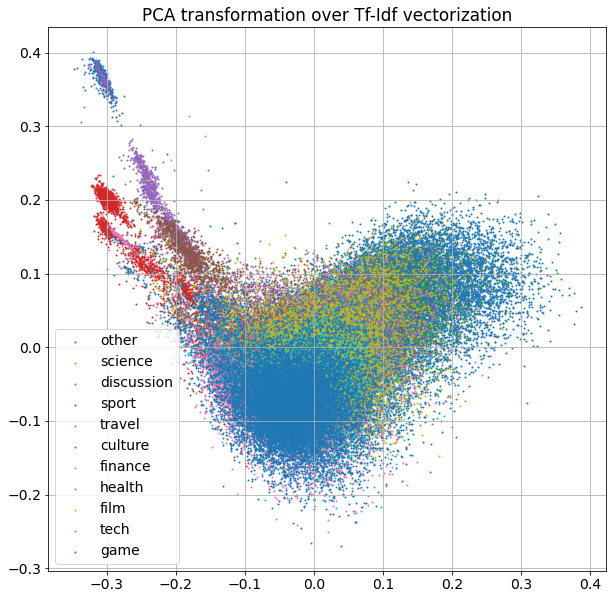

In [38]:
plt.figure(figsize=(10, 10))
plt.title("PCA transformation over Tf-Idf vectorization")
for topic in sbm_data["topic"].unique():
    plt.scatter(
        x=pca_tfidf_repr[sbm_data_wo_outliers["topic"] == topic][:, 0],
        y=pca_tfidf_repr[sbm_data_wo_outliers["topic"] == topic][:, 1],
        s=1,
        label=topic
    )
plt.legend()

## Выводы: 
1. Однозначно можно сказать, что для любой задачи классификации основными признаки должны быть построены на основе текста. Остальные признаки выступающие в роли метаданных документа малопригодны сами по себе. 
2. При предсказании оценки полезным признаком будет количество комментариев в силу замеченной выше корреляции. При тематическом моделировании могут быть использованы названия сабредиттов 
3. Обнаружение выбросов требует дальнейшего и более детального анализа, однако модель Isolation forest с выбранными параметрами может подойти в качестве первого приближения. 
4. Tf-idf преобразование показало достойный результат как модель построения признаков, распределив темы по отдельным областям (хоть и пересекающимся на графике). Для дальнейшего улучшения может быть использованы модели Word2Vec, FastText или Doc2Vec. 
5. Распределение тем неравномерное, что может в дальнейшем сказаться на результатах как классификации тем, так и их моделирования. Возможно, потребуется применение каких-либо метрик для устранения этого, например, сокращение числа документов с частыми темами, семплирование документов с редкими темами, объединение нескольких близких редких тем в одну или разделение частых тем на подтемы. В частности при PCA преобразовании 
